In [1]:
!wget https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/sample.csv
!wget https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/sample2.csv

--2025-08-06 10:07:09--  https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/sample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 179 [text/plain]
Saving to: ‘sample.csv’

sample.csv          100%[===================>]     179  --.-KB/s    in 0s      

2025-08-06 10:07:09 (3.08 MB/s) - ‘sample.csv’ saved [179/179]

--2025-08-06 10:07:09--  https://raw.githubusercontent.com/amirhoseinbidar/plot-proj/refs/heads/main/sample2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156 [text/plain]
Saving to: 

In [2]:
import pandas as pd

df = pd.read_csv('sample.csv')

In [3]:
df

,name,start,end,budget
0,Kinder,2024-01-01,2025-06-30,20000
1,TAP,2026-01-01,2028-06-30,30000
2,web,2025-01-01,2035-10-30,1000
3,p2,2024-09-01,2026-10-30,9400
4,p3,2028-01-01,2029-10-30,9400


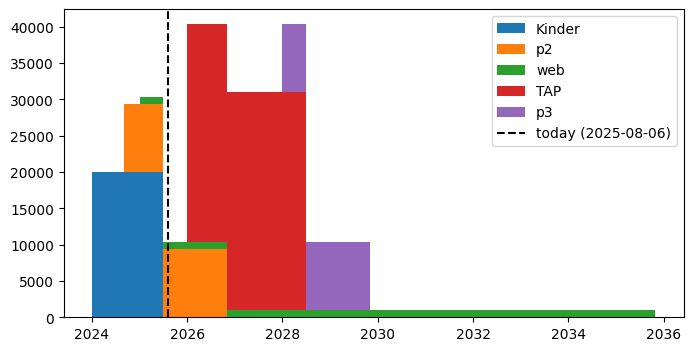

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

now = datetime.now()

edges = sorted(set(df["start"]).union(set(df["end"])))

values = {name: [0] * len(edges) for name in df["name"]}

sum = 0
for i, edge in enumerate(edges):
    active_records = df[(df["start"] <= edge) & (df["end"] > edge)]
    for idx, record in active_records.iterrows():
        values[record["name"]][i] = record["budget"]

y = np.vstack(list(values.values()))
x = np.array(edges, dtype="datetime64")

priority = ordered_names = df.sort_values(by="start")["name"].tolist()
y_priority = np.vstack([values[name] for name in priority])

fig, ax = plt.subplots(figsize=(8, 4))
ax.stackplot(x, y_priority, labels=priority, baseline="zero", step="post")
ax.axvline(
    x=now,
    color="black",
    label=f"today ({now.strftime('%Y-%m-%d')})",
    linestyle="dashed",
)

ax.legend()
plt.show()

In [5]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df = df.sort_values(by=['start'])
start_budget_map = df.groupby("start")["budget"].sum().to_dict()
end_budget_map = df.groupby("end")["budget"].sum().to_dict()
edges = sorted(set(df['start']).union(set(df['end'])))

values = []
sum = 0
for edge in edges:
    if edge in start_budget_map:
        sum += start_budget_map[edge]
    if edge in end_budget_map:
        sum -= end_budget_map[edge]
    values.append(sum)
values.pop()


0

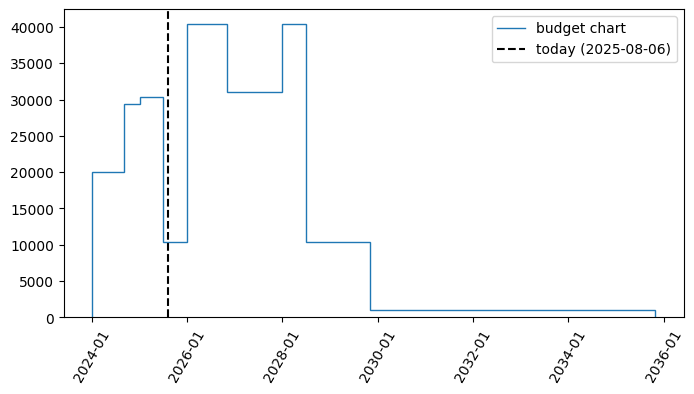

In [6]:
# Generate a step chart using the x and heights1 variables
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, ax = plt.subplots(figsize=(8, 4))
now = datetime.now()

ax.stairs(values, edges, label="budget chart", color="tab:blue")
ax.axvline(
    x=now,
    color="black",
    label=f"today ({now.strftime('%Y-%m-%d')})",
    linestyle="dashed",
)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=60)
ax.legend()
fig.show()

In [7]:
import pandas as pd

df = pd.read_csv('sample2.csv')
df

,staff,monthly-rate,start,end
0,bidar,600,2024-01-01,2026-01-30
1,ali,700,2025-09-01,2026-01-30
2,karim,200,2026-10-02,2027-09-30
3,hamid,1000,2027-06-02,2028-09-30


In [8]:
df["start"] = pd.to_datetime(df["start"])
df["end"] = pd.to_datetime(df["end"])
df = df.sort_values(by=["start"])
df["total-effect"] = df["monthly-rate"] * (df["end"] - df["start"]).dt.days / 30

start_rate_map = df.groupby("start")["monthly-rate"].sum().to_dict()
end_rate_map = df.groupby("end")["monthly-rate"].sum().to_dict()
end_drop_map = df.groupby("end")["total-effect"].sum().to_dict()

edges = sorted(set(df["start"]).union(set(df["end"])))

values = []
timestamps = []
sum = 0
rate = 0
previous_edge = edges[0]
for edge in edges:
    duration = (edge - previous_edge).days / 30
    sum += rate * duration
    values.append(sum)
    timestamps.append(edge)

    if edge in end_rate_map:
        # the amount of sum that decreases when a staff exits from project
        sum -= end_drop_map[edge]
        values.append(sum)
        timestamps.append(edge)
        rate -= end_rate_map[edge]

    if edge in start_rate_map:
        rate += start_rate_map[edge]

    previous_edge = edge


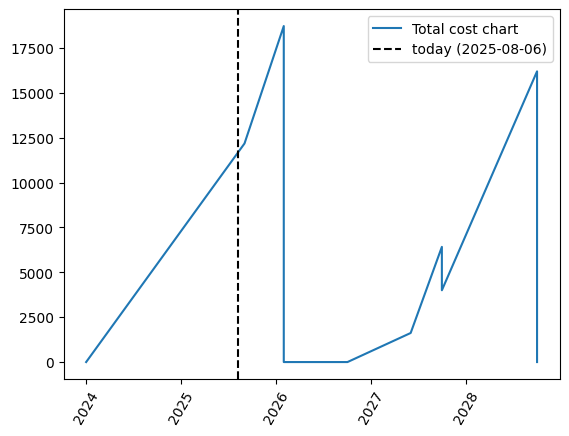

In [9]:
fig, ax = plt.subplots()

ax.plot(timestamps, values, label="Total cost chart" )
ax.axvline(
    x=now,
    color="black",
    label=f"today ({now.strftime('%Y-%m-%d')})",
    linestyle="dashed",
)
plt.xticks(rotation=60)
ax.legend()
fig.show()